In [3]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Kidney Treatment Analysis

You have data collected about an experimental kidney treatmeant, and you want to decide which treatment is more effective: A or B.

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

%matplotlib inline

data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/kidney_stone_data.csv"

<IPython.core.display.Javascript object>

* Read and inspect the data.  Do we have any missing values to deal with?

In [6]:
kidney = pd.read_csv(data_url)
kidney.shape

(700, 3)

<IPython.core.display.Javascript object>

In [7]:
kidney.head(2)

,treatment,stone_size,success
0,B,large,1
1,A,large,1


<IPython.core.display.Javascript object>

In [8]:
kidney.dtypes

treatment     object
stone_size    object
success        int64
dtype: object

<IPython.core.display.Javascript object>

In [12]:
kidney.isna().sum()

treatment     0
stone_size    0
success       0
dtype: int64

<IPython.core.display.Javascript object>

In [9]:
kidney["treatment"].value_counts()

A    350
B    350
Name: treatment, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
kidney["stone_size"].value_counts()

small    357
large    343
Name: stone_size, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
pd.crosstab(kidney["treatment"], kidney["stone_size"])

stone_size,large,small
treatment,,
A,263,87
B,80,270


<IPython.core.display.Javascript object>

Which treatment is more successful? How do we go about investigating this?

* Investigate the `pd.crosstab()` function and use it as a way to assess treatment A vs B.
* What do you conclude?

In [19]:
pd.crosstab(kidney["treatment"], kidney["success"], normalize="index")

success,0,1
treatment,,
A,0.220000,0.780000
B,0.174286,0.825714


<IPython.core.display.Javascript object>

We could more formally analyze these numbers with a $\chi^2$ ("chi square") test of independence.  See more on what this procedure is doing in this video from [Khan Academy](https://www.khanacademy.org/math/ap-statistics/chi-square-tests/chi-square-tests-two-way-tables/v/chi-square-test-association-independence).

What do you conclude from this test?

In [20]:
# Input your crosstab here w/o normalizing or row/col totals
crosstab = pd.crosstab(kidney["treatment"], kidney["success"])
chi2, p, df, expected = stats.chi2_contingency(crosstab)
p

0.15414040041998767

<IPython.core.display.Javascript object>

Now, include the `'stone_size'` column in your crosstab analysis.

What do you conlude?

In [24]:
pd.crosstab(
    [kidney["treatment"], kidney["stone_size"]], kidney["success"], normalize="index"
)

success                      0         1
treatment stone_size                    
A         large       0.269962  0.730038
          small       0.068966  0.931034
B         large       0.312500  0.687500
          small       0.133333  0.866667

<IPython.core.display.Javascript object>

The small effect seen in the success rates has reversed! For all stone sizes, treatment A has a higher success rate than treatment B. This is an example of Simpson's paradox:

> Simpson's paradox (or Simpson's reversal, Yule–Simpson effect, amalgamation paradox, or reversal paradox) is a phenomenon in probability and statistics, in which a trend appears in several different groups of data but disappears or reverses when these groups are combined.

from [Wikipedia](https://en.wikipedia.org/wiki/Simpson%27s_paradox)

----

If we were to run a $\chi^2$ test of independence:

In [25]:
# Input your crosstab here w/o normalizing or row/col totals
crosstab = pd.crosstab([kidney["treatment"], kidney["stone_size"]], kidney["success"])
chi2, p, df, expected = stats.chi2_contingency(crosstab)
p

6.626702248891721e-07

<IPython.core.display.Javascript object>

## Revisit online jelly sales for effect size and power

Reminder of context:

> You are a data scientist at a luxury jelly e-commerce retailer. In hopes of generating a recurring revenue stream, the retailer has decided to roll out a "Jelly of the Month Club".  Test to see if, during the experiment, purchase amount increased due to the sidebar testimonial.

<img src='https://i0.wp.com/scng-dash.digitalfirstmedia.com/wp-content/uploads/2019/11/LDN-L-CHEVYCHASE-1124-02.jpg?fit=620%2C9999px&ssl=1' width='20%'>
<center>"I love this luxury jelly" - Clark Griswold... prolly</center>

In [26]:
def get_95_ci(x1, x2):
    """Calculate a 95% CI for 2 1d numpy arrays"""
    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.var() / x1.size + x2.var() / x2.size)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    return ci_lo, ci_hi

<IPython.core.display.Javascript object>

In [27]:
# Below package is needed for pandas to read xl files
# !pip install xlrd
data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/a-b-testing-drill-start-06-14-19.xlsx"

df = pd.read_excel(data_url)

treatment = df[df["group"] == "treatment"]
control = df[df["group"] == "control"]

# The tetimon
t, p = stats.ttest_ind(treatment["cart_amount"], control["cart_amount"])
p

0.004419762574245763

<IPython.core.display.Javascript object>

In [28]:
get_95_ci(treatment["cart_amount"], control["cart_amount"])

(0.09857614433327516, 0.5415951112541717)

<IPython.core.display.Javascript object>

Based on this analysis, we are seeing a difference in sales based on whether or not customers were shown the sidebar testimonial.  The customers who were shown the testimonial spent about \\$0.10 - \\$0.54 more than customers in the control group.

### Effect size

To calculate a point estimate of the size of the effect, we might calculate Cohen's D, this measure is known as the 'effect size'.  This is similar to what our confidence interval is doing but as a single value rather than a range.  The formula for this calculation is:

$$d = \frac{\overline{x_1} - \overline{x_2}}{s_{pooled}}$$

Where $\overline{x_1}$ and $\overline{x_2}$ are the sample means & $s_{pooled}$ is a 'pooled standard deviation' (i.e. a measure of variability that includes both samples).  We can calculate this pooled standard deviation with:

$$s_{pooled} = \sqrt{\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}}$$

* Calculate Cohen's D for our `'cart_amount'` example

In [33]:
x1 = treatment["cart_amount"]
x2 = control["cart_amount"]

<IPython.core.display.Javascript object>

In [34]:
x1.std()

2.216948337987247

<IPython.core.display.Javascript object>

In [35]:
x2.std()

2.520646872238275

<IPython.core.display.Javascript object>

In [36]:
s_pooled_numerator = (x1.size - 1) * x1.var() + (x2.size - 1) * x2.var()
s_pooled_denominator = x1.size + x2.size - 2

s_pooled = np.sqrt(s_pooled_numerator / s_pooled_denominator)
s_pooled

2.3661475919303294

<IPython.core.display.Javascript object>

In [37]:
# 95% CI was: (0.0986, 0.5416)
effect_size = (x1.mean() - x2.mean()) / s_pooled
effect_size

0.13527711833588285

<IPython.core.display.Javascript object>

In [39]:
# If asked about 
# "how much more money will we make per quarter with this?"
# Assuming in a quarter we have 10000 customers

# Using CI
10000 * 0.0986
10000 * 0.5416

# Using effect size 
10000 * 0.1353

985.9999999999999


5416.0

<IPython.core.display.Javascript object>

Note, this isn't dead center of our confidence interval, it's a little more conservative (it's leaning more towards a difference of zero rather than a more extreme difference).  In practice, I think you should lean more towards confidence intervals and keep this calculation in your back pocket if asked for a point estimate.  Business people are typically pretty understanding of a confidence interval style interpretation and it allows us to more explicitly state the uncertainity in the effect size.

### Power

Statistical Power - the probability of rejecting the null hypothesis when it is in fact false

A great resource for going deeper: [A Gentle Introduction to Statistical Power and Power Analysis in Python](https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/).  A quote from the resource:

> A power analysis can be used to estimate the minimum sample size required for an experiment, given a desired significance level, effect size, and statistical power.


Note, given 3/4 of these metrics (effect size, significance level, power, and sample size) we can work out the 4th.

* What is the power of our test on `'cart_amount'`
  * We'll be using the [`.solve_power()`](https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestIndPower.solve_power.html#statsmodels.stats.power.TTestIndPower.solve_power) method of the `TTestIndPower()` object.  View it's documentation for us to figure out how to use it.

In [43]:
analysis = TTestIndPower()

# Type 1 Error - False positive (reject null when no effect)
# Type 2 Error - False negative (fail to reject null when there is an effect)

analysis.solve_power(
    effect_size=effect_size, nobs1=x1.size, alpha=0.05, ratio=x1.size / x2.size
)

# 15% chance of type 2

0.8492744678134502

<IPython.core.display.Javascript object>

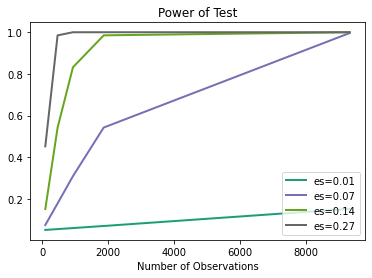

<IPython.core.display.Javascript object>

In [45]:
# Renaming just to reuse without a lot of extra typing
n = x1.size
es = effect_size

# Making up potential sample/effect sizes that relate to what we observe
sample_sizes = np.array([n * 0.1, n * 0.5, n, n * 2, n * 10])
effect_sizes = np.array([es * 0.1, es * 0.5, es, es * 2])

# Plot the power if we had these sample/effect sizes
analysis.plot_power(
    dep_var="nobs", nobs=sample_sizes, alpha=0.05, effect_size=effect_sizes
)
plt.show()

# Let's p-hack!

First, let's go over the theory behind it

### Sample size and the t statistic

In a t-test, the p value is directly related to t statistic.  As t increases, p decreases.  The definition of t is below.

$$t = \frac{signal}{noise} = \frac{\overline{x}_{1}-\overline{x}_{2}}{\sqrt{\frac{s_{1}^{2}}{n_{1}}+\frac{s_{2}^{2}}{n_{2}}}}$$

The denominator (aka $noise$) is the component that is affected by sample size.  The intuition behind this is that as your sample increases you should be drowning out the 'noisy' observations and the result is less noise overall.

This means as as `n` increases, our denominator decreases.  In fractions/division, when we hold the numerator constant and the denominator gets smaller, the result gets larger (e.g. $\frac{1}{4} = 0.25$ & $\frac{1}{2} = 0.5$).

All of this builds up to... our t statistic will get larger as `n` increases (assuming everything else stays relatively the same).

----

Enough with the theory, prove it.  We have 2 means and standard deviations defined below.

In [47]:
mean_x1 = 11
mean_x2 = 10
std_x1 = 2
std_x2 = 2

<IPython.core.display.Javascript object>

* Write a `for` loop that loops over the different values in the `ns` list
* In each iteration, calculate a `t` and `p` value for the given means, standard deviations, and value of `n` (assume both groups had `n` observations).
* Store the p values in a list to print/plot the relationship between p and n

In [48]:
ns = [10, 50, 100, 500, 1000, 5000]
ps = []
for n in ns:
    signal = mean_x1 - mean_x2
    noise = np.sqrt(std_x1 ** 2 / n + std_x2 ** 2 / n)
    t = signal / noise

    # Look up p value for given value of t and sample size
    p = stats.t.sf(np.abs(t), 2 * n - 2) * 2
    ps.append(p)

<IPython.core.display.Javascript object>

In [49]:
ps

[0.2782527548882589,
 0.014079755374771973,
 0.0005066924914804269,
 7.026151807527151e-15,
 3.4280567802594304e-28,
 7.456808408782501e-134]

<IPython.core.display.Javascript object>

### Sample size and the confidence interval

The formula we've been using for a 95% confidence interval for a t-test is shown below.  Reason out what will happen to our confidence interval as sample size increases.

$$\overline{X}_{1}-\overline{X}_{2} \pm 1.96 * {\sqrt{\frac{s_{1}^{2}}{n_{1}}+\frac{s_{2}^{2}}{n_{2}}}}$$

Write a for loop similar to the one above but this time with a focus on confidence intervals.  What happens to the confidence interval as n increases?

[(-0.753077294359835, 2.753077294359835), (0.21599999999999997, 1.784), (0.4456282835497467, 1.5543717164502533), (0.7520774314427991, 1.2479225685572009), (0.8246922705640165, 1.1753077294359835), (0.9216, 1.0784)]


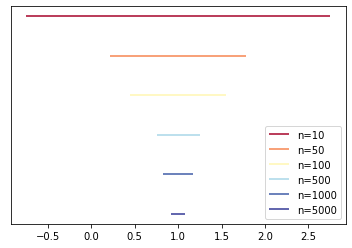

<IPython.core.display.Javascript object>

In [55]:
ns = [10, 50, 100, 500, 1000, 5000]
cis = []
for i, n in enumerate(ns):
    signal = mean_x1 - mean_x2
    noise = np.sqrt((std_x1 ** 2 / n) + (std_x2 ** 2 / n))

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    ci = (ci_lo, ci_hi)
    cis.append(ci)

    color = plt.cm.RdYlBu(i * 60)
    plt.hlines(len(ns) - i, ci_lo, ci_hi, colors=[color], label=f"n={n}")

print(cis)

plt.yticks([])
plt.legend(loc="lower right")
plt.show()